# Neural Collapse and Data Distillatioin

This notebook implements data distillation with neural collapse by only one step. The main papers considered here are https://github.com/SsnL/dataset-distillation and https://github.com/tding1/Neural-Collapse. The neural network is firstly trained to its terminal phase and then distills synthesized data as introduced. Below we configure our path to the dataset distillation packages from https://github.com/SsnL/dataset-distillation.

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import DataLoader, Dataset
import numpy as np
import copy
from contextlib import contextmanager

from six import add_metaclass
from typing import Type, Any, Callable, Union, List, Optional

# Import

In [29]:
import models
from models.resnet import ResNet, BasicBlock
from utils import *
from train_2nd_order import weight_decay, trainer
from validate_NC import compute_Wh_b_relation, compute_W_H_relation, compute_ETF, compute_Sigma_B, compute_Sigma_W,compute_info,FCFeatures
from datasets import make_dataset

# Load Parameters

In [30]:
# architecture params
model='resnet18'

# dataset
dataset='mnist'
data_dir='~/data'

# training params
optimizer="LBFGS"
lr=0.1
history_size=10
batch_size=128
uid="result"
device = "cpu"
SOTA=False

# Network params
loss = 'CrossEntropy'
bias=True
ETF_fc=False
fixdim=0

In [31]:
class args:
    def __init__(self, model='resnet18', bias=True, ETF_fc=False, fixdim=0, SOTA=False,
                 width=1024, depth=6, gpu_id=0, seed=6, use_cudnn=True,
                 dataset='mnist', data_dir='~/data', uid=None, force=False,
                 epochs=200, batch_size=1024, loss='CrossEntropy', sample_size=None,
                 lr=0.1, patience=40, decay_type='step', gamma = 0.1, optimizer='SGD',
                 weight_decay=5e-4, sep_decay=False, feature_decay_rate=1e-4,
                 history_size=10, ghost_batch=128, device = "cpu",
                 
                 # distill setting
                 distill_steps=10,
                 distill_epochs=3,
                 distilled_images_per_class_per_step=1,
                 num_classes = None,
                 distill_lr = 0.02,
                 decay_epochs = 40,
                 decay_factor = 0.5
                ):

        self.model = model
        self.bias = bias
        self.ETF_fc = ETF_fc
        self.fixdim = fixdim
        self.SOTA = SOTA
        self.width = width
        self.depth = depth
        self.gpu_id = gpu_id
        self.seed = seed
        self.use_cudnn = use_cudnn
        self.dataset = dataset
        self.data_dir = data_dir
        self.uid = uid
        self.force = force
        self.epochs = epochs
        self.batch_size = batch_size
        self.loss = loss
        self.sample_size = sample_size
        self.lr = lr
        self.patience = patience
        self.decay_type = decay_type
        self.gamma = gamma
        self.optimizer = optimizer
        self.weight_decay = weight_decay
        self.sep_decay = sep_decay
        self.feature_decay_rate = feature_decay_rate
        self.history_size = history_size
        self.ghost_batch = ghost_batch
        self.device = device
        
        # distill setting
        self.distill_steps = distill_steps
        self.distill_epochs = distill_epochs
        self.num_classes = num_classes
        self.distilled_images_per_class_per_step = distilled_images_per_class_per_step
        self.distill_lr = distill_lr
        self.decay_epochs = decay_epochs,
        self.decay_factor = decay_factor

In [32]:
args = args(model=model, dataset=dataset, optimizer=optimizer, lr = lr, loss = loss,
            history_size=history_size, batch_size = batch_size,
            uid = uid, device = device)

# Load Dataset

In [33]:
trainloader, _, num_classes = make_dataset(dataset, 
                                           data_dir, 
                                           batch_size, 
                                           SOTA=SOTA)
print(num_classes)

Dataset: MNIST.
10


In [34]:
images, labels = next(iter(trainloader))
size_train, channels, height, width = images.shape
num_classes = len(torch.unique(labels))
nc = channels
input_size = height, width
print("The number of class in our training set is ", num_classes)
print("Batch size:", size_train, "Number of channels:", channels, "input height:", height, "input width:", width)

The number of class in our training set is  10
Batch size: 128 Number of channels: 3 input height: 32 input width: 32


# Load Model

In [35]:
model = models.__dict__[args.model](num_classes=num_classes, 
                                    fc_bias=bias, 
                                    ETF_fc=ETF_fc, 
                                    fixdim=fixdim, 
                                    SOTA=SOTA).to(args.device)

print('# of model parameters: ' + str(count_network_parameters(model)))
print(type(model))

# of model parameters: 11181642
<class 'models.resnet.ResNet'>


In [36]:
class LeNet(nn.Module):
    supported_dims = {28, 32}

    def __init__(self, nc, num_classes, input_size, dropout = False):
        if dropout:
            raise ValueError("LeNet doesn't support dropout")
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(nc, 6, 5, padding=2 if input_size == 28 else 0)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1 if num_classes <= 2 else num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x), inplace=True)
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out), inplace=True)
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out), inplace=True)
        out = F.relu(self.fc2(out), inplace=True)
        out = self.fc3(out)
        return out


In [25]:
model = LeNet(nc, num_classes, input_size[0])
# model = ExtendedModule(model)
print('# of model parameters: ' + str(count_network_parameters(model)))
print(type(model))

# of model parameters: 62006
<class '__main__.LeNet'>


# Show neural collapse

In [37]:
def trainer(args, model, trainloader, epoch_id, criterion, optimizer):

    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    for batch_idx, (inputs, targets) in enumerate(trainloader):

        inputs, targets = inputs.to(args.device), targets.to(args.device)

        model.train()

        def closure():
            outputs = model(inputs)

            if args.loss == 'CrossEntropy':
                loss = criterion(outputs[0], targets) + weight_decay(args, model)
            elif args.loss == 'MSE':
                loss = criterion(outputs[0], nn.functional.one_hot(targets).type(torch.FloatTensor).to(args.device)) \
                       + weight_decay(args, model)

            optimizer.zero_grad()
            loss.backward()

            return loss

        optimizer.step(closure)

        # measure accuracy and record loss
        model.eval()
        outputs = model(inputs)
        prec1, prec5 = compute_accuracy(outputs[0].data, targets.data, topk=(1, 5))

        if args.loss == 'CrossEntropy':
            loss = criterion(outputs[0], targets) + weight_decay(args, model)
        elif args.loss == 'MSE':
            loss = criterion(outputs[0], nn.functional.one_hot(targets).type(torch.FloatTensor).to(args.device)) \
                   + weight_decay(args, model)

        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1.item(), inputs.size(0))
        top5.update(prec5.item(), inputs.size(0))

        if batch_idx % 10 == 0:
            print('[epoch: %d] (%d/%d) | Loss: %.4f | top1: %.4f | top5: %.4f ' %
                           (epoch_id + 1, batch_idx + 1, len(trainloader), losses.avg, top1.avg, top5.avg))


In [38]:
criterion = make_criterion(args)
optimizer = make_optimizer(args, model)

# logfile = open('%s/log.txt' % (args.save_path), 'w')

for epoch_id in range(args.epochs):
    trainer(args, model, trainloader, epoch_id, criterion, optimizer)
#     torch.save(model.state_dict(), args.save_path + "/epoch_" + str(epoch_id + 1).zfill(3) + ".pth")

# logfile.close()

[epoch: 1] (1/469) | Loss: 5.3102 | top1: 19.5312 | top5: 68.7500 
[epoch: 1] (11/469) | Loss: 3.5722 | top1: 88.6364 | top5: 96.3778 
[epoch: 1] (21/469) | Loss: 3.3577 | top1: 93.9732 | top5: 98.1027 
[epoch: 1] (31/469) | Loss: 3.2701 | top1: 95.8417 | top5: 98.7147 
[epoch: 1] (41/469) | Loss: 3.2221 | top1: 96.6463 | top5: 99.0282 
[epoch: 1] (51/469) | Loss: 3.1854 | top1: 97.2886 | top5: 99.2188 
[epoch: 1] (61/469) | Loss: 3.1988 | top1: 94.5953 | top5: 99.0651 
[epoch: 1] (71/469) | Loss: 2.9673 | top1: 92.0665 | top5: 98.9657 
[epoch: 1] (81/469) | Loss: 2.6818 | top1: 92.9784 | top5: 99.0934 
[epoch: 1] (91/469) | Loss: 2.4571 | top1: 93.5525 | top5: 99.1930 
[epoch: 1] (101/469) | Loss: 2.2905 | top1: 93.5566 | top5: 99.1955 
[epoch: 1] (111/469) | Loss: 2.1272 | top1: 93.9119 | top5: 99.2680 
[epoch: 1] (121/469) | Loss: 1.9844 | top1: 94.3763 | top5: 99.3285 
[epoch: 1] (131/469) | Loss: 1.8615 | top1: 94.7996 | top5: 99.3798 
[epoch: 1] (141/469) | Loss: 1.7562 | top1: 9

KeyboardInterrupt: 

# Validation of Neural Collapse

In [85]:
fc_features = FCFeatures()
model.fc.register_forward_pre_hook(fc_features)
info_dict = {
        'collapse_metric': [],
        'ETF_metric': [],
        'WH_relation_metric': [],
        'Wh_b_relation_metric': [],
        'W': [],
        'b': [],
        'H': [],
        'mu_G_train': [],
        # 'mu_G_test': [],
        'train_acc1': [],
        'train_acc5': [],
        'test_acc1': [],
        'test_acc5': []
    }

for i in range(args.epochs):

        model.load_state_dict()
        model.eval()

        for n, p in model.named_parameters():
            if 'fc.weight' in n:
                W = p
            if 'fc.bias' in n:
                b = p

        mu_G_train, mu_c_dict_train, train_acc1, train_acc5 = compute_info(args, model, fc_features, trainloader, isTrain=True)
        mu_G_test, mu_c_dict_test, test_acc1, test_acc5 = compute_info(args, model, fc_features, testloader, isTrain=False)

        Sigma_W = compute_Sigma_W(args, model, fc_features, mu_c_dict_train, trainloader, isTrain=True)
        # Sigma_W_test_norm = compute_Sigma_W(args, model, fc_features, mu_c_dict_train, testloader, isTrain=False)
        Sigma_B = compute_Sigma_B(mu_c_dict_train, mu_G_train)

        collapse_metric = np.trace(Sigma_W @ scilin.pinv(Sigma_B)) / len(mu_c_dict_train)
        ETF_metric = compute_ETF(W)
        WH_relation_metric, H = compute_W_H_relation(W, mu_c_dict_train, mu_G_train)
        if args.bias:
            Wh_b_relation_metric = compute_Wh_b_relation(W, mu_G_train, b)
        else:
            Wh_b_relation_metric = compute_Wh_b_relation(W, mu_G_train, torch.zeros((W.shape[0], )))

        info_dict['collapse_metric'].append(collapse_metric)
        info_dict['ETF_metric'].append(ETF_metric)
        info_dict['WH_relation_metric'].append(WH_relation_metric)
        info_dict['Wh_b_relation_metric'].append(Wh_b_relation_metric)

        info_dict['W'].append((W.detach().cpu().numpy()))
        if args.bias:
            info_dict['b'].append(b.detach().cpu().numpy())
        info_dict['H'].append(H.detach().cpu().numpy())

        info_dict['mu_G_train'].append(mu_G_train.detach().cpu().numpy())
        # info_dict['mu_G_test'].append(mu_G_test.detach().cpu().numpy())

        info_dict['train_acc1'].append(train_acc1)
        info_dict['train_acc5'].append(train_acc5)
        info_dict['test_acc1'].append(test_acc1)
        info_dict['test_acc5'].append(test_acc5)

        print_and_save('[epoch: %d] | train top1: %.4f | train top5: %.4f | test top1: %.4f | test top5: %.4f ' %
                       (i + 1, train_acc1, train_acc5, test_acc1, test_acc5))


TypeError: Module.load_state_dict() missing 1 required positional argument: 'state_dict'

# Data Distillation

Let's distill our data with the neural collapse weight. The weight is frozen throughout the distillation process.

In [26]:
def generate_distilled_images(model, num_classes=10, num_images_per_class=10, image_shape=(3, 28, 28), device="cpu"):
    criterion = nn.CrossEntropyLoss()  # Define the loss function

    model.eval()  # Ensure the model is in evaluation mode

    # Labels
    labels = torch.arange(num_classes, dtype=torch.long, device=device) \
                .repeat_interleave(num_images_per_class)

    # Data
    distilled_images = nn.ParameterList()
    initial_images = []  # List to store the initial state of images
    for _ in range(num_classes * num_images_per_class):
        img = torch.rand(image_shape, device=device)
        initial_images.append(img.clone())  # Clone and store the initial state
        distilled_images.append(nn.Parameter(img))  # Add as a parameter for optimization

    # Optimizer
    optimizer = optim.Adam(distilled_images.parameters(), lr=0.01)

    # Distillation process
    for _ in range(10000):  # Number of optimization steps
        optimizer.zero_grad()
        images_tensor = torch.cat([img.unsqueeze(0) for img in distilled_images])
        output = model(images_tensor)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    # Detach the images from the graph for output
    final_distilled_images = [img.detach() for img in distilled_images]
    return initial_images, final_distilled_images, labels

# Example usage
device = "cpu"  # Change to "cuda" if using GPU
model = LeNet(nc, num_classes=10, input_size=input_size[0])  # Adjust LeNet or your model accordingly
model.to(device)
initial_data, distilled_images, distilled_labels = generate_distilled_images(
    model, 
    num_classes=10, 
    num_images_per_class=1, 
    image_shape=(nc, input_size[0], input_size[1]), 
    device=device
)


Let's visualize our distilled image.

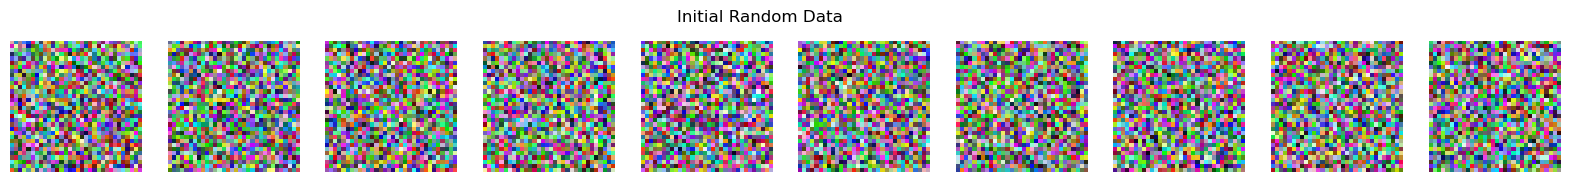

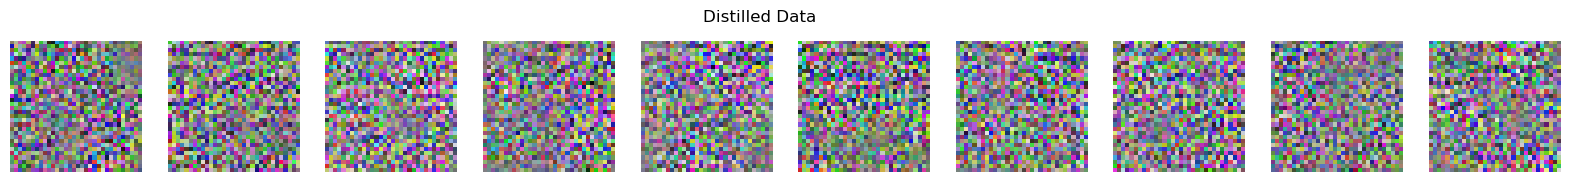

In [27]:
import matplotlib.pyplot as plt

def plot_images(data, title="Images", num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    fig.suptitle(title)

    for i, ax in enumerate(axes):
        # Detach the tensor, move to CPU, convert to numpy, and transpose dimensions
        # Transpose from (C, H, W) to (H, W, C)
        image = data[i].detach().cpu().numpy().transpose(1, 2, 0)
        
        # Normalize the image to [0, 1] for correct visualization
        image = (image - image.min()) / (image.max() - image.min())

        ax.imshow(image)
        ax.axis('off')

    plt.show()

# Example usage (assuming initial_data and distilled_images are lists of tensors)
# Plot initial data
plot_images(initial_data, title="Initial Random Data")

# Plot distilled data
plot_images(distilled_images, title="Distilled Data")

